In [1]:
import sys
sys.path.append('./src/')
import os
os.chdir("../")

In [2]:
import json
import joblib
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from preprocessing import encode_labels


In [3]:
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

In [4]:
config_file = "config.json"
with open(config_file, 'r') as f:
    config = json.load(f)

In [5]:
model_path = "./models/model_bst.pkl"
model, class_names = joblib.load(model_path)
class_map= {class_names[i]:i for i in range(len(class_names))}
class_map


{'constant': 0, 'multi': 1, 'normal': 2, 'rapid': 3}

In [6]:
test_data_path = config['processed_test_data_path']
df_test = pd.read_csv(test_data_path)
y0_test = df_test['cluster']
X_test = df_test.drop(columns={'cluster','well'})
y_test, _ = encode_labels(y0_test)
y_test_pred = model.predict(X_test)
y_test_pred

array([0, 2, 2, 3, 0, 1, 0, 0, 2, 2, 0, 2, 0, 0, 2, 2, 2, 0, 2, 2, 2, 0,
       2, 2, 2, 0, 0, 2, 3, 0, 2, 0, 2, 0, 2, 2, 0, 0, 0, 0, 0, 0, 2, 0,
       1, 2, 0, 2, 0, 0, 1, 0, 1, 2, 0, 0, 2, 0, 0, 2, 2, 2, 2, 2, 2, 2,
       2, 0, 2, 2, 0, 2, 2, 2, 2, 2, 2, 0, 2, 0, 0, 1, 2, 0, 2, 0, 0, 1,
       2])

In [7]:
norm_conf_mx = confusion_matrix(y_test, y_test_pred,normalize='true')
norm_conf_mx

array([[0.375     , 0.03125   , 0.59375   , 0.        ],
       [0.375     , 0.125     , 0.5       , 0.        ],
       [0.46666667, 0.1       , 0.43333333, 0.        ],
       [0.45454545, 0.        , 0.36363636, 0.18181818]])

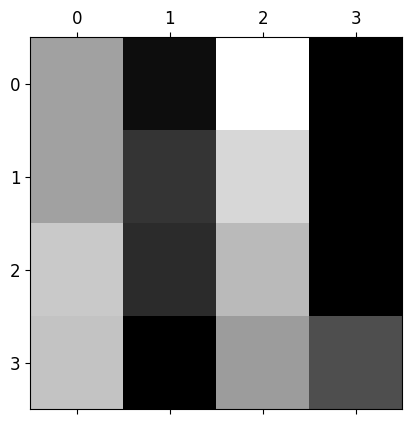

In [8]:
plt.matshow(norm_conf_mx, cmap=plt.cm.gray)
plt.show()

* The column of class 2 is bright, which tells you that many samples get misclassified as 2s. 
* 
* sample 2 is confused with sample 0 
* Sample 3 is all over the place, it gets confused with 0, 1, and mostly with  2.
* never, anyclass is confused as sample 3

**How can we reduce the false 2s?**

In [9]:
(df_test
 .filter(['well','cluster'])
 .assign(y = lambda df: df['cluster'].map(class_map))
 .drop(columns={'cluster'})
 .assign(p = y_test_pred)
 .query("y == 0 and p == 0")
)


,well,y,p
6,well_128,0,0
7,well_132,0,0
10,well_143,0,0
21,well_251,0,0
25,well_271,0,0
26,well_275,0,0
31,well_306,0,0
38,well_35,0,0
40,well_357,0,0
67,well_516,0,0


In [10]:
(df_test
 .filter(['well','cluster'])
 .assign(y = lambda df: df['cluster'].map(class_map))
 .drop(columns={'cluster'})
 .assign(p = y_test_pred)
 .query("y == 0 and p == 2")
)


,well,y,p
2,well_120,0,2
9,well_142,0,2
14,well_161,0,2
16,well_190,0,2
18,well_2,0,2
20,well_250,0,2
22,well_259,0,2
23,well_266,0,2
24,well_269,0,2
27,well_276,0,2


In [11]:
well_id = 'well_120'
df_well = (pd.read_csv(config['test_data_path'],parse_dates=['date'])
 .groupby('well')
 .get_group(well_id)
 .sort_values(['date'])
 #.filter(['date','value'])
 .set_index('date')
)
df_well.head()

,well,value,cluster
date,,,
1977-03-01,well_120,1.771429,constant
1977-04-01,well_120,1.843750,constant
1977-05-01,well_120,0.481928,constant
1977-06-01,well_120,0.000000,constant
1977-07-01,well_120,0.717949,constant


In [12]:
well_cluster = df_well['cluster'].iloc[0]
well_cluster

'constant'

In [13]:
df_well_Y = df_well[["value"]].resample('Y').mean()
df_well_Y.head()

/var/folders/1n/2j_57fhs4hd7p8xz6gg76p7w0000gn/T/ipykernel_18839/3203870136.py:1: FutureWarning: 'Y' is deprecated and will be removed in a future version, please use 'YE' instead.
  df_well_Y = df_well[["value"]].resample('Y').mean()


,value
date,
1977-12-31,0.814464
1978-12-31,0.848213
1979-12-31,1.002060
1980-12-31,2.366487
1981-12-31,1.911037


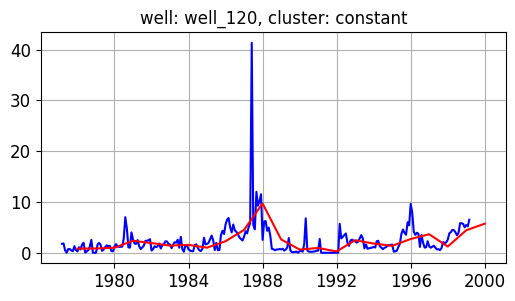

In [14]:
plt.figure(figsize=(6,3))
plt.plot(df_well.index, df_well.value,color='blue')
plt.title(f'well: {well_id}, cluster: {well_cluster}')
plt.grid(True)
plt.plot(df_well_Y.index, df_well_Y.value,color='red')
plt.show()

In [15]:
wells_00 = (df_test
 .filter(['well','cluster'])
 .assign(y = lambda df: df['cluster'].map(class_map))
 .drop(columns={'cluster'})
 .assign(p = y_test_pred)
 .query("y == 0 and p==0")
 .well
 .to_list()
)
wells_01 = (df_test
 .filter(['well','cluster'])
 .assign(y = lambda df: df['cluster'].map(class_map))
 .drop(columns={'cluster'})
 .assign(p = y_test_pred)
 .query("y == 0 and p==1")
 .well
 .to_list()
)
wells_10 = (df_test
 .filter(['well','cluster'])
 .assign(y = lambda df: df['cluster'].map(class_map))
 .drop(columns={'cluster'})
 .assign(p = y_test_pred)
 .query("y == 1 and p==0")
 .well
 .to_list()
)
wells_11 = (df_test
 .filter(['well','cluster'])
 .assign(y = lambda df: df['cluster'].map(class_map))
 .drop(columns={'cluster'})
 .assign(p = y_test_pred)
 .query("y == 1 and p==1")
 .well
 .to_list()
)
len(wells_00), len(wells_01), len(wells_10), len(wells_11)


(12, 1, 6, 2)

In [16]:
wells_00

['well_128',
 'well_132',
 'well_143',
 'well_251',
 'well_271',
 'well_275',
 'well_306',
 'well_35',
 'well_357',
 'well_516',
 'well_576',
 'well_87']

In [17]:
df_00 = (pd.read_csv(config['test_data_path'],parse_dates=['date'])
            .sort_values(['date'])
            #.query("cluster == 'constant'")
            .pivot(index='well', columns='date', values='value')
            #.sample(25)
            .loc[wells_00]
)
df_01 = (pd.read_csv(config['test_data_path'],parse_dates=['date'])
            .sort_values(['date'])
            #.query("cluster == 'constant'")
            .pivot(index='well', columns='date', values='value')
            #.sample(25)
            .loc[wells_01]
)
df_10 = (pd.read_csv(config['test_data_path'],parse_dates=['date'])
            .sort_values(['date'])
            #.query("cluster == 'constant'")
            .pivot(index='well', columns='date', values='value')
            #.sample(25)
            .loc[wells_10]
)
df_11 = (pd.read_csv(config['test_data_path'],parse_dates=['date'])
            .sort_values(['date'])
            #.query("cluster == 'constant'")
            .pivot(index='well', columns='date', values='value')
            #.sample(25)
            .loc[wells_11]
)


In [18]:
df_00

date,1977-01-01,1977-02-01,1977-03-01,1977-04-01,1977-05-01,1977-06-01,1977-07-01,1977-08-01,1977-09-01,1977-10-01,...,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01
well,,,,,,,,,,,,,,,,,,,,,
well_128,NaN,NaN,3.950100,4.317814,4.403509,4.126697,2.875850,3.877193,3.080692,4.290113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
well_132,NaN,NaN,24.000000,36.036680,332.333333,40.665480,61.500000,49.000000,44.454545,46.617958,...,19.011628,11.448171,11.535135,14.256944,17.399160,16.958525,17.229665,16.901460,15.559633,NaN
well_143,NaN,NaN,8.706625,11.497738,14.872340,17.179283,14.384409,13.705722,13.083851,15.392523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
well_251,42.573754,41.906874,54.713675,62.812500,42.376054,41.453429,42.145015,34.730290,34.615385,35.346284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
well_271,73.117241,65.523105,55.043937,0.000000,58.067545,57.161644,51.428205,54.545455,66.886121,64.046699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
well_275,36.545259,37.129697,45.406763,0.000000,34.599369,34.743137,32.271795,33.170472,40.506466,38.435626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
well_306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077114,0.051546,0.059846,...,0.245062,0.223899,0.271578,0.323396,0.360731,0.120205,0.111515,0.125696,0.088814,NaN
well_35,NaN,2.850498,0.000000,0.000000,0.000000,0.000000,5.682432,5.478528,4.609626,5.167539,...,7.599222,7.600775,7.600000,7.598540,7.600000,7.598540,7.600000,7.600000,NaN,NaN
well_357,NaN,NaN,30.203333,20.298901,25.796143,29.431438,30.046053,30.572289,32.406897,27.885294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


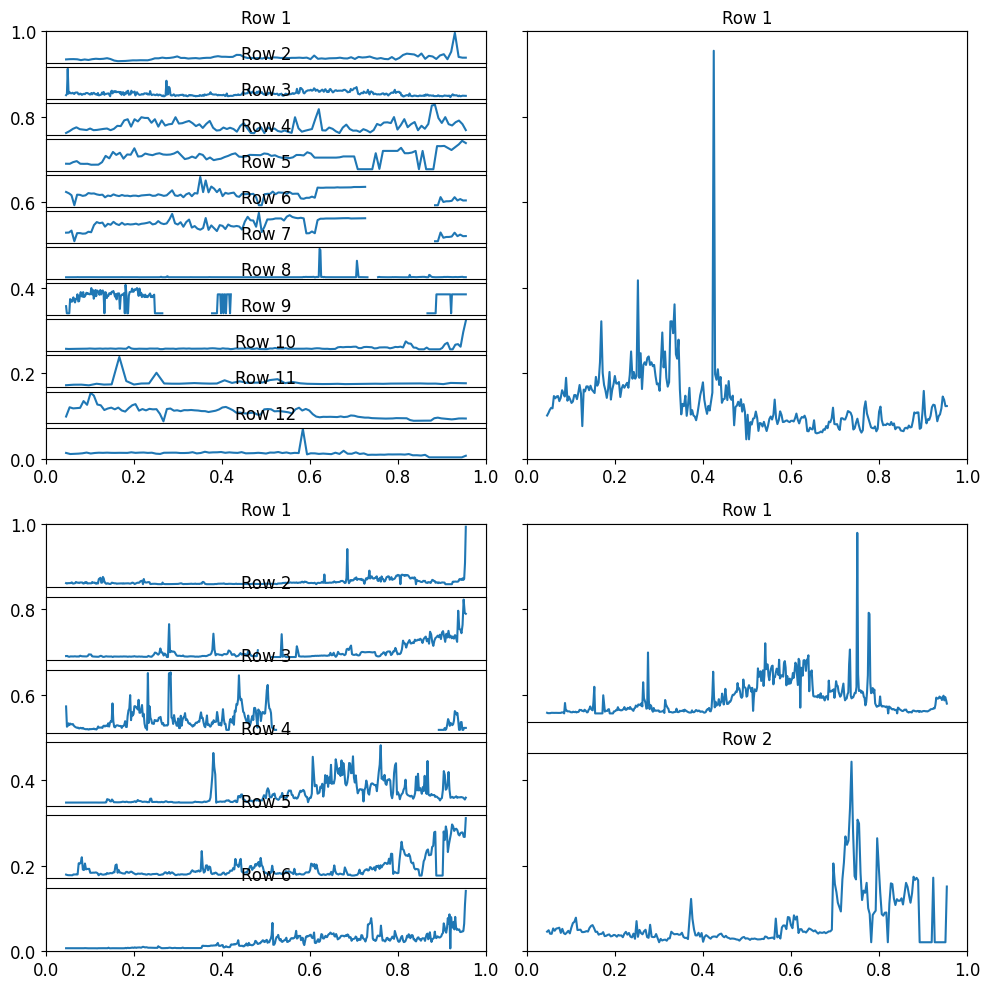

In [19]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

# Create sample dataframes
df1 = pd.DataFrame({'y1': np.random.rand(100),
                    'y2': np.random.rand(100),
                    'y3': np.random.rand(100),
                    'y4': np.random.rand(100)},
                    index=range(100))

df2 = pd.DataFrame({'y1': np.random.rand(100),
                    'y2': np.random.rand(100),
                    'y3': np.random.rand(100),
                    'y4': np.random.rand(100)},
                    index=range(100))

df3 = pd.DataFrame({'y1': np.random.rand(100),
                    'y2': np.random.rand(100),
                    'y3': np.random.rand(100),
                    'y4': np.random.rand(100)},
                    index=range(100))

df4 = pd.DataFrame({'y1': np.random.rand(100),
                    'y2': np.random.rand(100),
                    'y3': np.random.rand(100),
                    'y4': np.random.rand(100)},
                    index=range(100))

pivot_tables = [df_00, df_01, df_10, df_11]

# Create the main figure and axes
fig, big_axes = plt.subplots(figsize=(10.0, 10.0), nrows=2, ncols=2, sharey=True)

for idx, (pivot_table, big_ax_row) in enumerate(zip(pivot_tables, big_axes.flatten()), start=1):
    for inner_row in range(len(pivot_table)):
        ax = fig.add_subplot(big_ax_row.get_subplotspec().subgridspec(len(pivot_table), 1)[inner_row, 0])
        row_data = pivot_table.iloc[inner_row]
        ax.plot(row_data.index, row_data.values)
        ax.set_title(f'Row {inner_row+1}')
        ax.set_xticks([])
        ax.set_yticks([])

plt.tight_layout()
plt.show()


In [20]:
df_00

date,1977-01-01,1977-02-01,1977-03-01,1977-04-01,1977-05-01,1977-06-01,1977-07-01,1977-08-01,1977-09-01,1977-10-01,...,2017-05-01,2017-06-01,2017-07-01,2017-08-01,2017-09-01,2017-10-01,2017-11-01,2017-12-01,2018-01-01,2018-02-01
well,,,,,,,,,,,,,,,,,,,,,
well_128,NaN,NaN,3.950100,4.317814,4.403509,4.126697,2.875850,3.877193,3.080692,4.290113,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
well_132,NaN,NaN,24.000000,36.036680,332.333333,40.665480,61.500000,49.000000,44.454545,46.617958,...,19.011628,11.448171,11.535135,14.256944,17.399160,16.958525,17.229665,16.901460,15.559633,NaN
well_143,NaN,NaN,8.706625,11.497738,14.872340,17.179283,14.384409,13.705722,13.083851,15.392523,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
well_251,42.573754,41.906874,54.713675,62.812500,42.376054,41.453429,42.145015,34.730290,34.615385,35.346284,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
well_271,73.117241,65.523105,55.043937,0.000000,58.067545,57.161644,51.428205,54.545455,66.886121,64.046699,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
well_275,36.545259,37.129697,45.406763,0.000000,34.599369,34.743137,32.271795,33.170472,40.506466,38.435626,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
well_306,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.077114,0.051546,0.059846,...,0.245062,0.223899,0.271578,0.323396,0.360731,0.120205,0.111515,0.125696,0.088814,NaN
well_35,NaN,2.850498,0.000000,0.000000,0.000000,0.000000,5.682432,5.478528,4.609626,5.167539,...,7.599222,7.600775,7.600000,7.598540,7.600000,7.598540,7.600000,7.600000,NaN,NaN
well_357,NaN,NaN,30.203333,20.298901,25.796143,29.431438,30.046053,30.572289,32.406897,27.885294,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


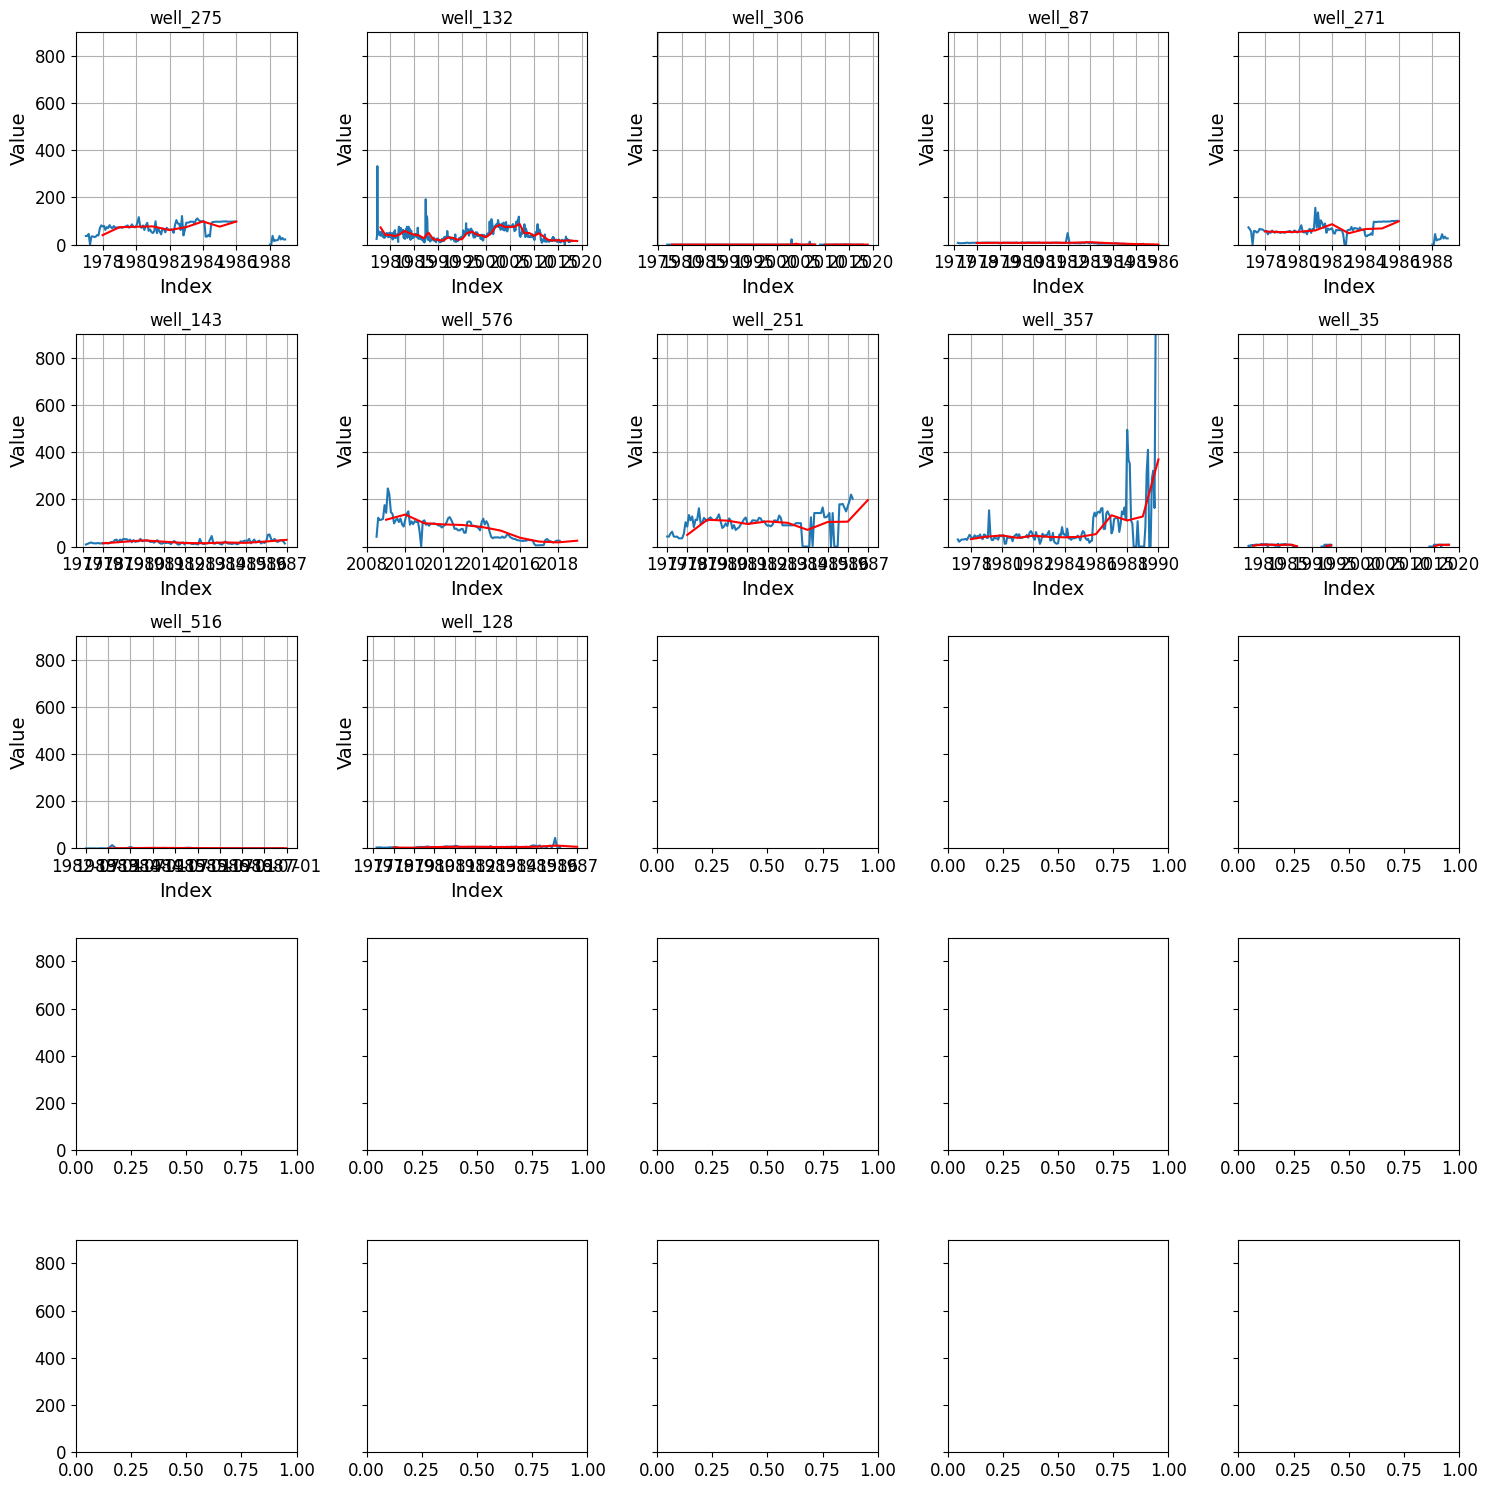

In [32]:

def plot_timeseries(df):
    
    y_min = df.min(axis='rows').min()
    y_max = df.quantile(0.75,axis='rows').max()
    
    fig, axes = plt.subplots(nrows=5, ncols=5, figsize=(15, 15),sharey= True)

# Flatten the axes array to iterate over each subplot
    axes = axes.flatten()
    num_rows = df.shape[0]
# Loop through each column and plot the data in each subplot
    for i,(index,row) in enumerate(df.iterrows()):
        ax = axes[i]  # Select the current subplot
        if i > num_rows:
            ax.axis('off')  # Turn off axis
            ax.set_xticks([])  # Remove x-axis ticks
            ax.set_xticks([], minor=True)  # Remove minor x-axis ticks as well

        else:
            
            ax.plot(row)  # Plot the data
            ax.plot(row.resample('YE').mean(),color = 'red')  # Plot the data
            ax.set_title(index)  # Set the title as the column name
            ax.grid(True)  # Add grid lines
            ax.set_xlabel('Index')  # X-axis label
            ax.set_ylabel('Value')  # Y-axis label
            plt.ylim(y_min, y_max)


# Adjust layout and display
    plt.tight_layout()
    plt.show()

plot_timeseries(df_00.sample(12))


In [36]:
size = 60
images_per_row = min(len(instances), images_per_row)
n_rows = (len(instances) - 1) // images_per_row + 1

NameError: name 'instances' is not defined

In [35]:
size = 60
images_per_row = min(len(instances), images_per_row)
n_rows = (len(instances) - 1) // images_per_row + 1

# Append empty images to fill the end of the grid, if needed:
n_empty = n_rows * images_per_row - len(instances)
padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

# Reshape the array so it's organized as a grid containing 28×28 images:
image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

# Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
# and axes 1 and 3 (horizontal axes). We first need to move the axes that we
# want to combine next to each other, using transpose(), and only then we
# can reshape:
big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                        images_per_row * size)
# Now that we have a big image, we just need to show it:
plt.imshow(big_image, cmap = mpl.cm.binary, **options)
plt.axis("off")

60

In [ ]:
def plot_ts(instances, images_per_row=10, **options):
    size = 60
    images_per_row = min(len(instances), images_per_row)
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")

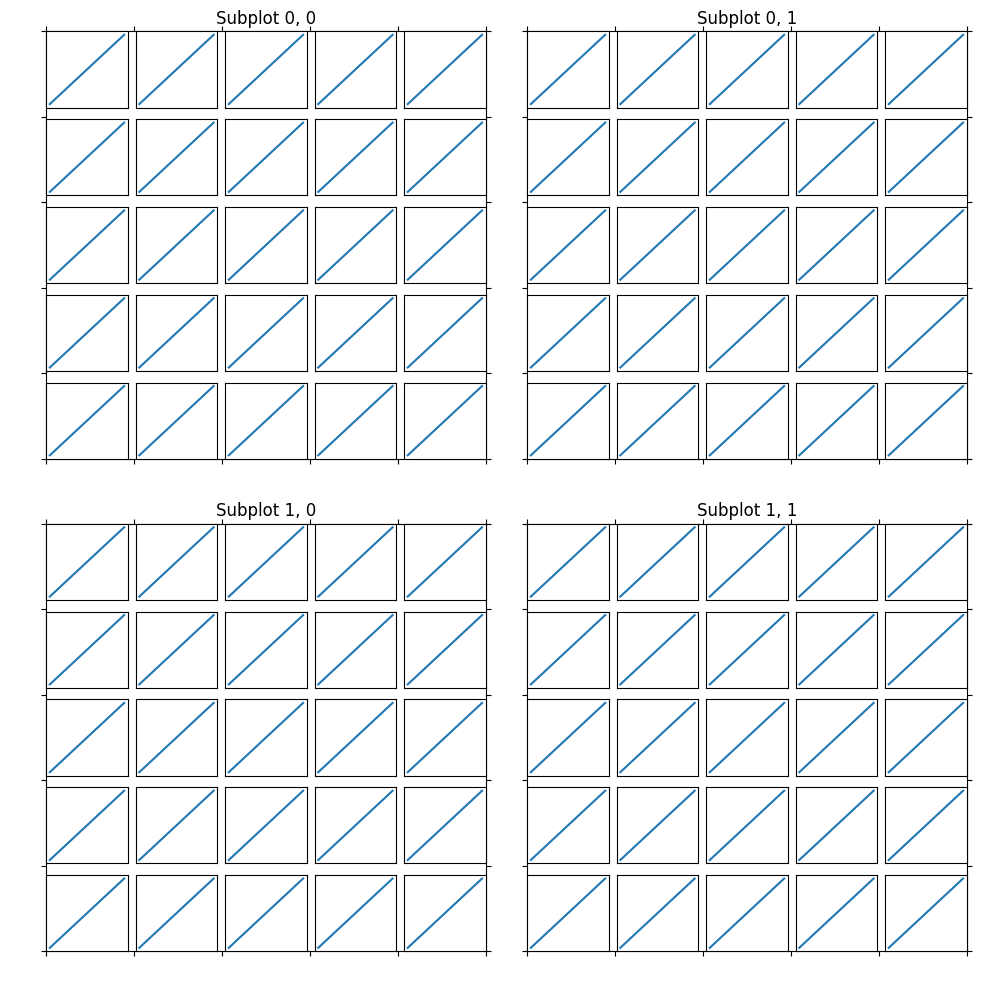

In [26]:
import matplotlib.pyplot as plt

fig, big_axes = plt.subplots(figsize=(10.0, 10.0), nrows=2, ncols=2, sharey=True)

for row, big_ax_row in enumerate(big_axes):
    for col, big_ax in enumerate(big_ax_row):
        big_ax.set_title(f'Subplot {row}, {col}')
        big_ax.tick_params(labelcolor=(1.,1.,1., 0.0), top='off', bottom='off', left='off', right='off')

        inner_grid = big_ax.get_subplotspec().subgridspec(5, 5)

        for inner_row in range(5):
            for inner_col in range(5):
                ax = fig.add_subplot(inner_grid[inner_row, inner_col])
                ax.plot(data)
                ax.set_xticks([])
                ax.set_yticks([])

plt.tight_layout()
plt.show()



In [21]:
# Plot each row in a subplot
num_plots = len(pivot_df)
num_cols = 3
num_rows = 3

plt.figure(figsize=(1,1))
y_min = pivot_df.min().min()
y_max = pivot_df.max().max()
for i, (well, row) in enumerate(pivot_df.iterrows(), 1):
    plt.subplot(num_rows, num_cols, i)
    plt.plot(row.values)
    #plt.title(well)
    #plt.xlabel('Date')
    #plt.ylabel('Value')
    plt.ylim(y_min, 500)
    plt.box(False)  # Remove bounding box
    plt.xticks([])   # Remove x-axis ticks
    plt.yticks([])   # Remove y-axis ticks


plt.tight_layout(pad=.01)
plt.show()

NameError: name 'pivot_df' is not defined

In [22]:
def find_common_limits(df):
    common_x_min = df.columns.min()
    common_x_max = df.columns.max()
    common_y_min = df.min().min()
    common_y_max = df.max().max()
    return common_x_min, common_x_max, common_y_min, common_y_max
find_common_limits(df)

NameError: name 'df' is not defined

In [23]:
plt.figure(figsize=(1,1))
df_grouped = (pd.read_csv(config['test_data_path'],parse_dates=['date'])
              .groupby('well')
)
plt.figure(figsize=(10,10))

for i,well_id in enumerate(wells):
    df_well = (df_grouped
    .get_group(well_id)
    .sort_values(['date'])
    #.filter(['date','value'])
    .set_index('date')
    )
    plt.subplot(5, 5, i + 1)
    plt.plot(df_well.index, df_well.value,color='blue',alpha=0.5)
    plt.grid(True)

    df_well_Y = df_well[["value"]].resample('YE').mean()
    plt.plot(df_well_Y.index, df_well_Y.value,color='red',alpha=.5)
plt.show()

NameError: name 'wells' is not defined

<Figure size 100x100 with 0 Axes>

<Figure size 1000x1000 with 0 Axes>

In [24]:
# Describe statistics of the pivot table
pivot_stats = pivot_df.T.describe()
print(pivot_stats)

NameError: name 'pivot_df' is not defined

In [25]:
def plot_digits(instances, images_per_row=10, **options):
    size = 28
    images_per_row = min(len(instances), images_per_row)
    # This is equivalent to n_rows = ceil(len(instances) / images_per_row):
    n_rows = (len(instances) - 1) // images_per_row + 1

    # Append empty images to fill the end of the grid, if needed:
    n_empty = n_rows * images_per_row - len(instances)
    padded_instances = np.concatenate([instances, np.zeros((n_empty, size * size))], axis=0)

    # Reshape the array so it's organized as a grid containing 28×28 images:
    image_grid = padded_instances.reshape((n_rows, images_per_row, size, size))

    # Combine axes 0 and 2 (vertical image grid axis, and vertical image axis),
    # and axes 1 and 3 (horizontal axes). We first need to move the axes that we
    # want to combine next to each other, using transpose(), and only then we
    # can reshape:
    big_image = image_grid.transpose(0, 2, 1, 3).reshape(n_rows * size,
                                                         images_per_row * size)
    # Now that we have a big image, we just need to show it:
    plt.imshow(big_image, cmap = mpl.cm.binary, **options)
    plt.axis("off")